In [1]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
samples = ['The cat sat on the mat.', 'The dog ate my homework.']
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(samples)
sequences = tokenizer.fit_on_sequences(samples)
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')
word_index = tokenizer.word_index



In [2]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing
max_feature = 10000
maxlen = 20
(x_train, y_train), (x_test, y_test)= imdb.load_data(path='/Users/yangbao/PycharmProjects/datadig/mytest_ch6_RNN&LSTM/imdb.npz', num_words=max_feature)
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding
model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))

model.add(Flatten())

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()
history = model.fit(x_train,y_train, epochs=10, batch_size=32, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 8)             80000     
_________________________________________________________________
flatten (Flatten)            (None, 160)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 1s 1ms/step - loss: 0.6740 - acc: 0.6090 - val_loss: 0.6335 - val_acc: 0.6908

In [4]:
import os
imdb_dir = './aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
maxlen = 100
training_sample =200
validation_sample = 10000
max_word = 10000

tokenizer = Tokenizer(num_words=max_word)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index

data = pad_sequences(sequences,maxlen=maxlen)

labels = np.asarray(labels)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_sample]
y_train = labels[:training_sample]
x_val = data[training_sample:training_sample+validation_sample]
y_val = labels[training_sample:training_sample+validation_sample]

In [6]:
glove_dir = './glove'
embedding_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embedding_index[word] = coefs
f.close()

In [7]:
embedding_dim = 100
embedding_matrix = np.zeros((max_word, embedding_dim))
for word, i in word_index.items():
    if i <max_word:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding
model = Sequential()
model.add(Embedding(max_word, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.layers[0].set_weights(([embedding_matrix]))
model.layers[0].trainable = False

In [10]:
model.compile(optimizer='rmsprop',
              loss = 'binary_crossentropy',
              metrics=['acc'],)
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val,y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 0s 54ms/step - loss: 1.1454 - acc: 0.5300 - val_loss: 0.7078 - val_acc: 0.5156
Epoch 2/10
7/7 [==============================] - 0s 40ms/step - loss: 0.6394 - acc: 0.6500 - val_loss: 0.9214 - val_acc: 0.4959
Epoch 3/10
7/7 [==============================] - 0s 39ms/step - loss: 0.4264 - acc: 0.7950 - val_loss: 0.6864 - val_acc: 0.5625
Epoch 4/10
7/7 [==============================] - 0s 40ms/step - loss: 0.3190 - acc: 0.9200 - val_loss: 0.6949 - val_acc: 0.5689
Epoch 5/10
7/7 [==============================] - 0s 41ms/step - loss: 0.3370 - acc: 0.8450 - val_loss: 0.7769 - val_acc: 0.5380
Epoch 6/10
7/7 [==============================] - 0s 40ms/step - loss: 0.2230 - acc: 0.9450 - val_loss: 0.6855 - val_acc: 0.5753
Epoch 7/10
7/7 [============

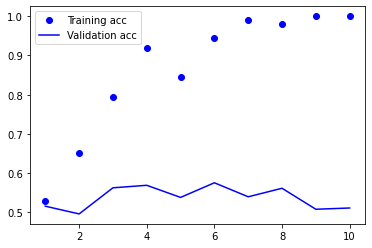

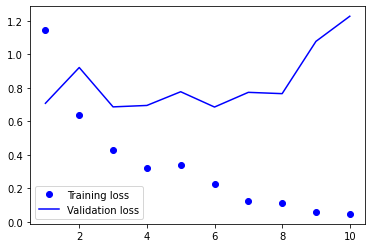

In [11]:
import  matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend()

plt.show()

In [17]:
str = 'I love you everyday'
list = []
list.append(str)
tokenizer.fit_on_texts(list)
sequences = tokenizer.texts_to_sequences(list)

word_index = tokenizer.word_index

x = pad_sequences(sequences,maxlen=maxlen)
predict = model.predict(x)
predict

array([[0.6657046]], dtype=float32)

0